### **Application to analyze the credit history and other related factors to predict customer loan eligibility, using Machine Learning Models**

In [ ]:
import pandas as pd 
import numpy as np                     # For mathematical calculations 
import seaborn as sns                  # For data visualization 
import matplotlib.pyplot as plt        # For plotting graphs 
%matplotlib inline 
import warnings                        # To ignore any warnings
warnings.filterwarnings("ignore")
import config

#Importing models for classification efficiency
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn import metrics
from sklearn.metrics import confusion_matrix


### **Introduction**
##### In this Jupyter notebook, we will be analyzing data and build models based on several factors, to help predict customer loan eligibility. We will train the models and test to see which is the most efficient and accurate model to use for our predictions.<br> Further an application is developed to automate the loan eligibility process in real time based on the information provided by the customer applying for a loan.

##### **Exploratory Data Analysis**

##### Data loading

In [2]:
# Loading the dataset into a dataframe
loan = pd.read_csv('data/loan.csv')

In [3]:
# A quick look at the loan data
loan

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y
...,...,...,...,...,...,...,...,...,...,...,...,...,...
609,LP002978,Female,No,0,Graduate,No,2900,0.0,71.0,360.0,1.0,Rural,Y
610,LP002979,Male,Yes,3+,Graduate,No,4106,0.0,40.0,180.0,1.0,Rural,Y
611,LP002983,Male,Yes,1,Graduate,No,8072,240.0,253.0,360.0,1.0,Urban,Y
612,LP002984,Male,Yes,2,Graduate,No,7583,0.0,187.0,360.0,1.0,Urban,Y


In [68]:
# Create a connection to postgres database
engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(config.username, config.password, 'localhost', 5432, 'loan_db'))
con = engine.connect()

In [69]:
# Create the loan table in the database
loan.to_sql('loan', con, if_exists='replace', index=False)

In [70]:
# Query the loan table
loan = pd.read_sql_query('select * from loan', con=engine)
loan

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,1,0,0,0,0,5849,0.0,146.412162,360.0,1.0,2,1
1,LP001003,1,1,1,0,0,4583,1508.0,128.000000,360.0,1.0,0,0
2,LP001005,1,1,0,0,1,3000,0.0,66.000000,360.0,1.0,2,1
3,LP001006,1,1,0,1,0,2583,2358.0,120.000000,360.0,1.0,2,1
4,LP001008,1,0,0,0,0,6000,0.0,141.000000,360.0,1.0,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
609,LP002978,0,0,0,0,0,2900,0.0,71.000000,360.0,1.0,0,1
610,LP002979,1,1,3,0,0,4106,0.0,40.000000,180.0,1.0,0,1
611,LP002983,1,1,1,0,0,8072,240.0,253.000000,360.0,1.0,2,1
612,LP002984,1,1,2,0,0,7583,0.0,187.000000,360.0,1.0,2,1


In [7]:
# Confirm that the data was loaded into the loan database
loan.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


##### Data exploration

In [8]:
# Description of the loan data
loan.describe()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History
count,614.000000,614.000000,592.000000,600.00000,564.000000
mean,5403.459283,1621.245798,146.412162,342.00000,0.842199
std,6109.041673,2926.248369,85.587325,65.12041,0.364878
min,150.000000,0.000000,9.000000,12.00000,0.000000
25%,2877.500000,0.000000,100.000000,360.00000,1.000000
50%,3812.500000,1188.500000,128.000000,360.00000,1.000000
75%,5795.000000,2297.250000,168.000000,360.00000,1.000000
max,81000.000000,41667.000000,700.000000,480.00000,1.000000


In [9]:
# Information about the loan data
loan.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            614 non-null    object 
 1   Gender             601 non-null    object 
 2   Married            611 non-null    object 
 3   Dependents         599 non-null    object 
 4   Education          614 non-null    object 
 5   Self_Employed      582 non-null    object 
 6   ApplicantIncome    614 non-null    int64  
 7   CoapplicantIncome  614 non-null    float64
 8   LoanAmount         592 non-null    float64
 9   Loan_Amount_Term   600 non-null    float64
 10  Credit_History     564 non-null    float64
 11  Property_Area      614 non-null    object 
 12  Loan_Status        614 non-null    object 
dtypes: float64(4), int64(1), object(8)
memory usage: 62.5+ KB


In [10]:
# Checking the number of rows and columns
loan.shape

(614, 13)

In [11]:
# Get the column names
loan_columns = loan.columns
print(loan_columns)

Index(['Loan_ID', 'Gender', 'Married', 'Dependents', 'Education',
       'Self_Employed', 'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount',
       'Loan_Amount_Term', 'Credit_History', 'Property_Area', 'Loan_Status'],
      dtype='object')


In [12]:
# Function to explore data types of the columns and the count
def explore_data(df, feature):
    print(df[feature].value_counts())
    print(df[feature].dtype)

In [13]:
# Explore the data
for featureName in loan_columns:
      print('\n"' + str(featureName) + '\'s" Values with count are :')
      explore_data(loan, str(featureName))


"Loan_ID's" Values with count are :
LP001002    1
LP002328    1
LP002305    1
LP002308    1
LP002314    1
           ..
LP001692    1
LP001693    1
LP001698    1
LP001699    1
LP002990    1
Name: Loan_ID, Length: 614, dtype: int64
object

"Gender's" Values with count are :
Male      489
Female    112
Name: Gender, dtype: int64
object

"Married's" Values with count are :
Yes    398
No     213
Name: Married, dtype: int64
object

"Dependents's" Values with count are :
0     345
1     102
2     101
3+     51
Name: Dependents, dtype: int64
object

"Education's" Values with count are :
Graduate        480
Not Graduate    134
Name: Education, dtype: int64
object

"Self_Employed's" Values with count are :
No     500
Yes     82
Name: Self_Employed, dtype: int64
object

"ApplicantIncome's" Values with count are :
2500    9
4583    6
6000    6
2600    6
3333    5
       ..
3244    1
4408    1
3917    1
3992    1
7583    1
Name: ApplicantIncome, Length: 505, dtype: int64
int64

"CoapplicantIncome

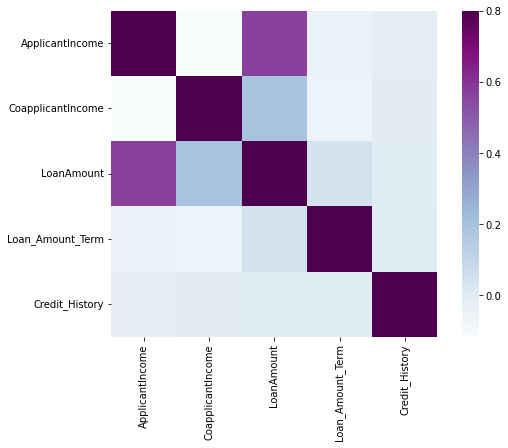

In [14]:
# Finding correlation between the variables
matrix =loan.corr() 
f, ax = plt.subplots(figsize=(9, 6)) 
sns.heatmap(matrix, vmax=.8, square=True, cmap="BuPu");

##### Data Transformation

##### **Missing value and outlier treatment**

In [15]:
# Checking for null values
loan.isnull().sum()

Loan_ID               0
Gender               13
Married               3
Dependents           15
Education             0
Self_Employed        32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
Loan_Status           0
dtype: int64

In [16]:
# Imputing missing values using simple imputer and mean strategy
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
loan_n = loan.iloc[:, 8:11]
dependat =loan['Dependents']
dependat = dependat.replace('3+', 3)
loan_n1 = loan.iloc[:, 3:4]
imputer.fit(loan_n)
loan_n = imputer.transform(loan_n)
loan_d = pd.DataFrame(loan_n)

In [17]:
# Assigning the column names to the dataframe
loan['LoanAmount'],loan['Loan_Amount_Term'], loan['Credit_History'] = loan_d[0], loan_d[1], loan_d[2]


In [18]:
# Imputing other null variables
employ = loan['Self_Employed']
P_area = loan['Property_Area']
gender = loan["Gender"]
status = loan["Married"]
education = loan["Education"]
loan_status = loan['Loan_Status']

status = status.fillna("Yes")
gender = gender.fillna("Male")
P_area= P_area.fillna("Rural")
employ= employ.fillna("Yes")
dependat = dependat.fillna(1)

In [19]:
# Importing LabelEncoder
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()

In [20]:
# Initializing string variables to be Encoded

input_class = ["Male", "Female"]
input_class1 = ["Yes", "No"]
input_class2 = ["Rural", "Urban", "Semiurban"]
input_class3 = ["Graduate", "Not Graduate"]
input_class4 = ["Y", "N"]

label_encoder.fit(input_class)

gender = gender.iloc[:].values
gender = list(gender)
gender = label_encoder.transform(gender)

label_encoder.fit(input_class1)

status = status.iloc[:].values
employ = employ.iloc[:].values
employ = list(employ)
status = list(status)
status = label_encoder.transform(status)
employ = label_encoder.transform(employ)

label_encoder.fit(input_class2)
P_area = P_area.iloc[:].values
P_area = list(P_area)
P_area = label_encoder.transform(P_area)

label_encoder.fit(input_class3)

education = education.iloc[:].values
education = list(education)
education = label_encoder.transform(education)

label_encoder.fit(input_class4)

loan_status = loan_status.iloc[:].values
loan_status =list(loan_status)
loan_status = label_encoder.transform(loan_status)


In [21]:
# Creating a new dataframe with the encoded variables
loan['Education'],loan['Self_Employed'],loan['Property_Area'],loan["Gender"],loan["Married"], loan['Loan_Status'], loan['Dependents'] =education, employ, P_area, gender, status, loan_status, dependat

In [22]:
# Writing the encoded dataframe to a csv file
loan.head()
loan.to_csv("Loan Processed data.csv")

In [23]:
# Creating a data and target for the model
data = loan.iloc[:, 1:-1]
target = loan.iloc[:, -1:]

In [24]:
# A quick look at data 
data.head(5)

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area
0,1,0,0,0,0,5849,0.0,146.412162,360.0,1.0,2
1,1,1,1,0,0,4583,1508.0,128.000000,360.0,1.0,0
2,1,1,0,0,1,3000,0.0,66.000000,360.0,1.0,2
3,1,1,0,1,0,2583,2358.0,120.000000,360.0,1.0,2
4,1,0,0,0,0,6000,0.0,141.000000,360.0,1.0,2


In [25]:
# A quick look at target
target.head(2)

,Loan_Status
0,1
1,0


In [26]:
# Write the data and target to csv files
data.to_csv("Data.csv")
target.to_csv("Target.csv")

##### **Outlier treatment**

<AxesSubplot:xlabel='LoanAmount'>

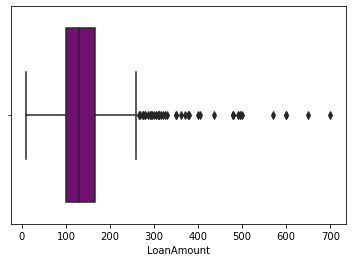

In [27]:
# Finding outliers
from turtle import title
sns.boxplot(x=loan['LoanAmount'], color="purple")

* We can see that there are a few outliers in the Loan amount applicants who were looking for loans in the range of 600K to 700K. The bulk of the data in the dataset is at the left and the right is sparse showing right skewness. We can apply log transformation to rectify the skewness.

##### **Training and testing the data with different machine learning models and compare their accuracies**


In [28]:
# Splitting the data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(data, target, test_size = 0.2, random_state=10)

In [29]:
print(x_train.shape)
print(x_test.shape)

(491, 11)
(123, 11)


### **Analysis of data**

##### **Univariate Analysis**

In [30]:
# Read loan processed data
clean_loan = pd.read_csv('Loan Processed data.csv')
clean_loan.head()

,Unnamed: 0,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,0,LP001002,1,0,0,0,0,5849,0.0,146.412162,360.0,1.0,2,1
1,1,LP001003,1,1,1,0,0,4583,1508.0,128.000000,360.0,1.0,0,0
2,2,LP001005,1,1,0,0,1,3000,0.0,66.000000,360.0,1.0,2,1
3,3,LP001006,1,1,0,1,0,2583,2358.0,120.000000,360.0,1.0,2,1
4,4,LP001008,1,0,0,0,0,6000,0.0,141.000000,360.0,1.0,2,1


In [31]:
# Let us see the count of approved and unapproved loans
clean_loan['Loan_Status'].value_counts()

1    422
0    192
Name: Loan_Status, dtype: int64

In [32]:
# Normalize the data to print proportions instead of number
clean_loan['Loan_Status'].value_counts(normalize=True)

1    0.687296
0    0.312704
Name: Loan_Status, dtype: float64

<AxesSubplot:title={'center':'Loan Status count'}>

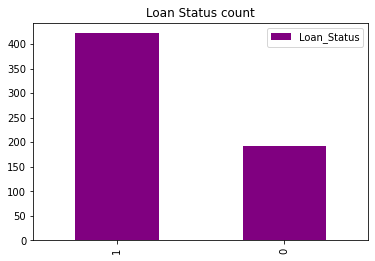

In [33]:
# Visualize the count of approved and unapproved loans with legend
loan['Loan_Status'].value_counts().plot.bar(title='Loan Status count', legend=True, color = 'purple')

##### Conclusion : 422(around 69%) people out of 614 got the approval for the loan.

<AxesSubplot:title={'center':'Credit_History(0-not good/1-good)'}>

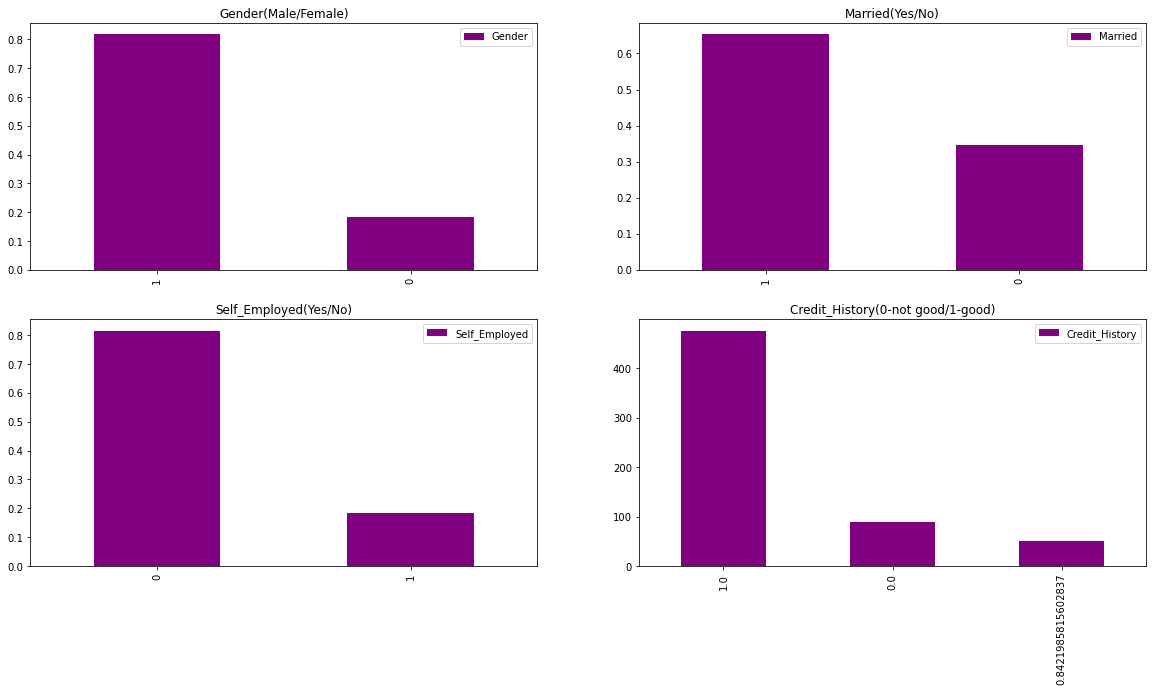

In [34]:
# Visualize the count for Gender, Married, Self_Employed, Credit_History, Property_Area, Education (Categorical Variables)
plt.figure(1)
plt.subplot(221)
clean_loan['Gender'].value_counts(normalize=True).plot.bar(figsize=(20,10), title='Gender(Male/Female)', color = 'purple', legend = True)
plt.subplot(222)
clean_loan['Married'].value_counts(normalize=True).plot.bar(title='Married(Yes/No)', color = 'purple', legend = True)
plt.subplot(223)
clean_loan['Self_Employed'].value_counts(normalize=True).plot.bar(title='Self_Employed(Yes/No)', color = 'purple', legend = True)
plt.subplot(224)
clean_loan['Credit_History'].value_counts().plot.bar(title='Credit_History(0-not good/1-good)', color = 'purple', legend = True)

##### It can be inferred from the above bar plots that:

* 80% of applicants in the dataset are male.
* Around 65% of the applicants in the dataset are married.
* About 15% of applicants in the dataset are self-employed.
* About 85% of applicants have repaid their debts.

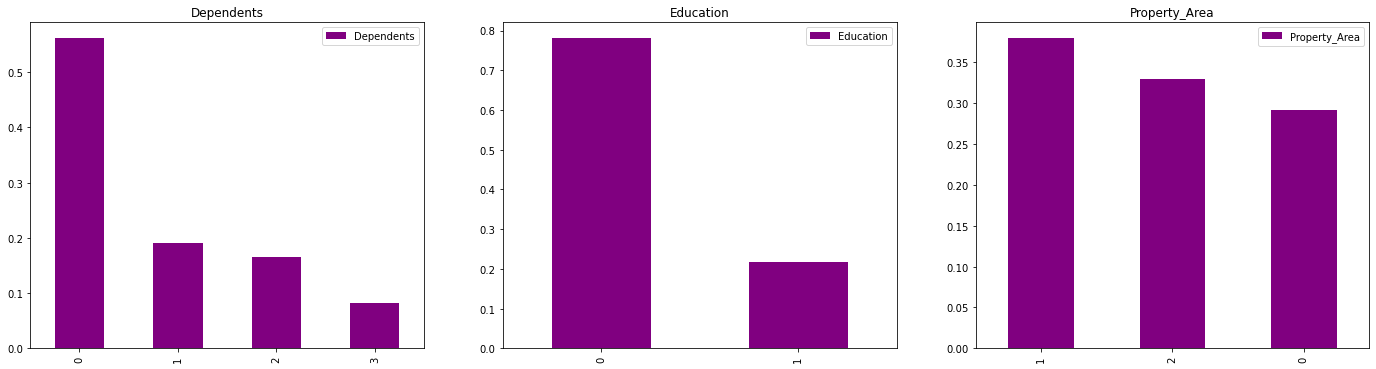

In [35]:
# Visualize the count for Dependents, Education, Property_Area (Ordinal Variables)
plt.figure(1) 
plt.subplot(131)
clean_loan['Dependents'].value_counts(normalize=True).plot.bar(figsize=(24,6),title='Dependents', color = 'purple', legend = True) 
plt.subplot(132)
clean_loan['Education'].value_counts(normalize=True).plot.bar(title= 'Education', color = 'purple', legend = True) 
plt.subplot(133) 
clean_loan['Property_Area'].value_counts(normalize=True).plot.bar(title= 'Property_Area', color = 'purple', legend = True)
plt.show()

##### Following inferences can be made from the above bar plots:

* Most of the applicants don’t have dependents.
* About 80% of the applicants are graduates.
* Most of the applicants are from semi-urban areas.

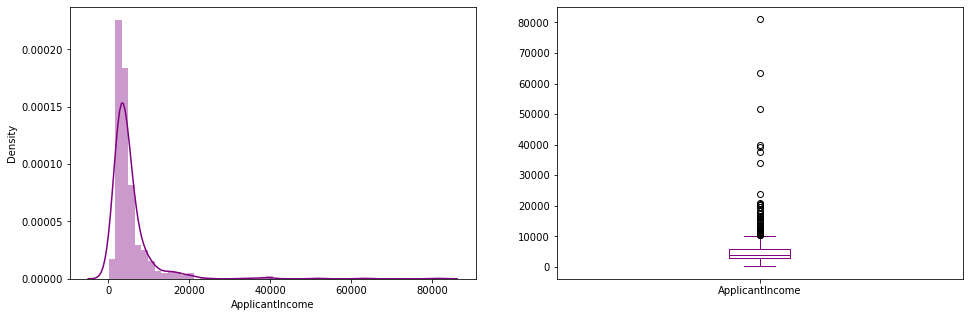

In [36]:
# Visualize the count for ApplicantIncome, CoapplicantIncome, LoanAmount, Loan_Amount_Term (Numerical Variables)
plt.figure(1) 
plt.subplot(121) 
sns.distplot(clean_loan['ApplicantIncome'], color = 'purple');
plt.subplot(122)
clean_loan['ApplicantIncome'].plot.box(figsize=(16,5), color = 'purple')
plt.show()

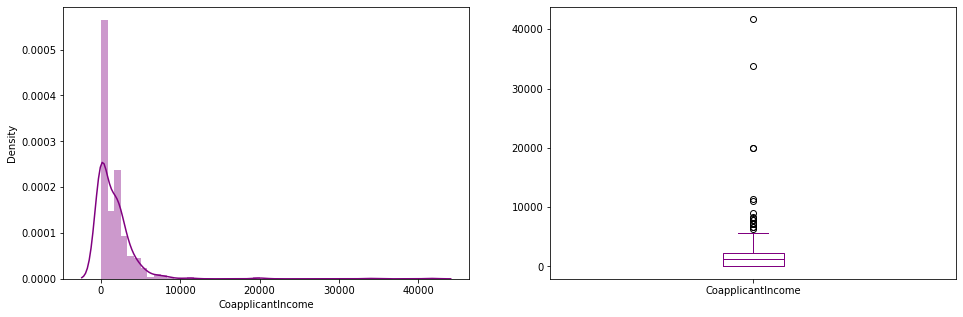

In [37]:
# Visualize the count for ApplicantIncome, CoapplicantIncome, LoanAmount, Loan_Amount_Term (Numerical Variables)
plt.figure(1) 
plt.subplot(121) 
sns.distplot(clean_loan['CoapplicantIncome'], color = 'purple');
plt.subplot(122)
clean_loan['CoapplicantIncome'].plot.box(figsize=(16,5), color = 'purple')
plt.show()

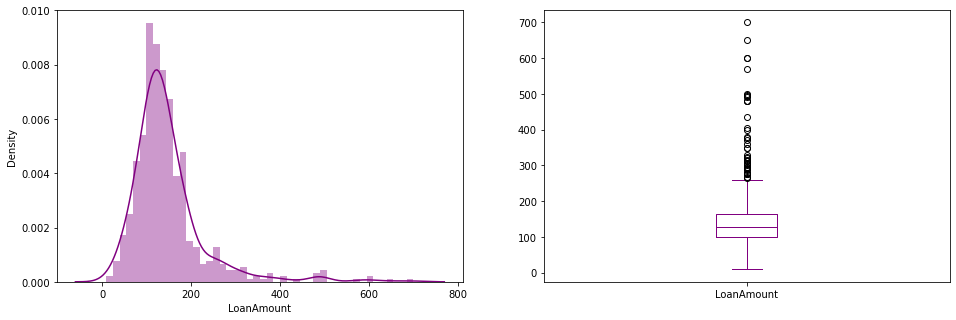

In [38]:
# Visualize the count for ApplicantIncome, CoapplicantIncome, LoanAmount, Loan_Amount_Term (Numerical Variables)
plt.figure(1) 
plt.subplot(121) 
sns.distplot(clean_loan['LoanAmount'], color = 'purple');
plt.subplot(122)
clean_loan['LoanAmount'].plot.box(figsize=(16,5), color = 'purple')
plt.show()

##### **Bivariate Analysis**<br>
Hypotheses:
* Applicants with high incomes should have more chances of loan approval.
* Applicants who have repaid their previous debts should have higher chances of loan approval.
* Loan approval should also depend on the loan amount. If the loan amount is less, the chances of loan approval should be high.
* Lesser the amount to be paid monthly to repay the loan, the higher the chances of loan approval.


<AxesSubplot:xlabel='Gender'>

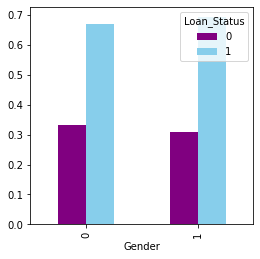

In [39]:
# Visualize the Loan approval status based on gender
Gender=pd.crosstab(clean_loan['Gender'],clean_loan['Loan_Status']) 
# create graph with colors  purple and blue
Gender.div(Gender.sum(1).astype(float), axis=0).plot(kind="bar", figsize=(4,4), color = ['purple', 'skyblue'])

* It can be inferred that the proportion of male and female applicants is more or less the same for both approved and unapproved loans.

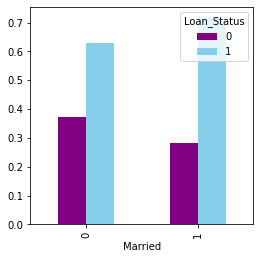

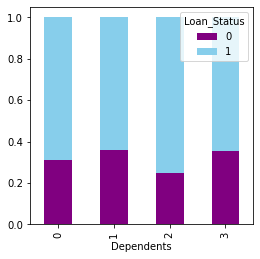

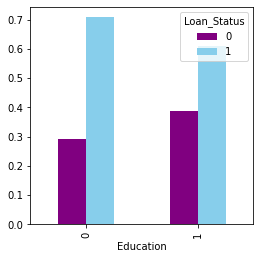

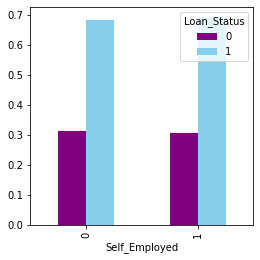

In [40]:
# Visualization of Loan approval status based on marital status, having dependents, education, self employed
Married=pd.crosstab(clean_loan['Married'],clean_loan['Loan_Status']) 
Dependents=pd.crosstab(clean_loan['Dependents'],clean_loan['Loan_Status']) 
Education=pd.crosstab(clean_loan['Education'],clean_loan['Loan_Status']) 
Self_Employed=pd.crosstab(clean_loan['Self_Employed'],clean_loan['Loan_Status']) 
Married.div(Married.sum(1).astype(float), axis=0).plot(kind="bar", figsize=(4,4), color = ['purple', 'skyblue']) 
plt.show() 
Dependents.div(Dependents.sum(1).astype(float), axis=0).plot(kind="bar", stacked=True, figsize=(4,4), color = ['purple', 'skyblue'])
plt.show() 
Education.div(Education.sum(1).astype(float), axis=0).plot(kind="bar", figsize=(4,4), color = ['purple', 'skyblue']) 
plt.show() 
Self_Employed.div(Self_Employed.sum(1).astype(float),axis=0).plot(kind="bar",figsize=(4,4), color = ['purple', 'skyblue'])
plt.show()

 * The proportion of married applicants is higher for the approved loans.
* The distribution of applicants with 1 or 3+ dependents is similar across both the categories of Loan_Status.
 * There is nothing significant we can infer from Self_Employed vs Loan_Status plot.

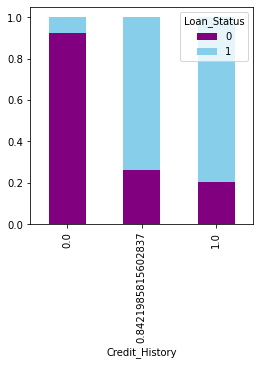

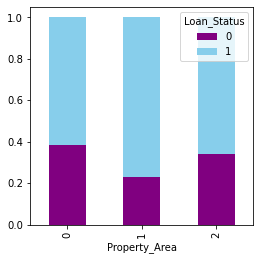

In [41]:
# Visualization of Loan approval status based on credit history and property area
Credit_History=pd.crosstab(clean_loan['Credit_History'],clean_loan['Loan_Status']) 
Property_Area=pd.crosstab(clean_loan['Property_Area'],clean_loan['Loan_Status']) 
Credit_History.div(Credit_History.sum(1).astype(float), axis=0).plot(kind="bar", stacked=True, figsize=(4,4), color = ['purple', 'skyblue']) 
plt.show() 
Property_Area.div(Property_Area.sum(1).astype(float), axis=0).plot(kind="bar", stacked=True, figsize=(4,4), color = ['purple', 'skyblue'])
plt.show()

#### **Numerical Independent Variable vs Target Variable**

<AxesSubplot:title={'center':'Applicant Income grouped by loan status'}, xlabel='Loan_Status'>

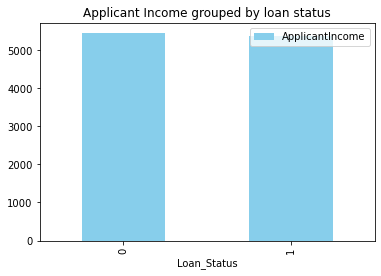

In [42]:
clean_loan.groupby('Loan_Status')['ApplicantIncome'].mean().plot.bar(color='skyblue', legend=True, title='Applicant Income grouped by loan status')

In [43]:
# Bin the ApplicantIncome variable into 4 bins
bins=[0,2500,4000,6000,81000] 
group=['Low','Average','High', 'Very high'] 
clean_loan['Income_bin']=pd.cut(clean_loan['ApplicantIncome'],bins,labels=group)

Text(0.5, 0, 'ApplicantIncome')

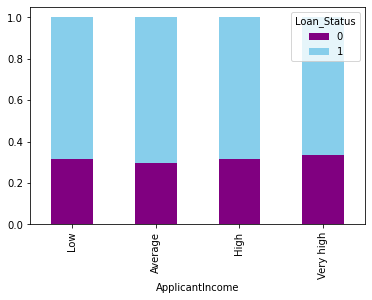

In [44]:
# Visualize the income bins by loan status
Income_bin=pd.crosstab(clean_loan['Income_bin'],clean_loan['Loan_Status'])
Income_bin.div(Income_bin.sum(1).astype(float), axis=0).plot(kind="bar", stacked=True, color = ['purple', 'skyblue'])
plt.xlabel('ApplicantIncome')

* It can be inferred that Applicant’s income does not affect the chances of loan approval which contradicts our hypothesis in which we assumed that if the applicant’s income is high the chances of loan approval will also be high.

In [45]:
# Bin the CoapplicantIncome variable into 3 bins
bins=[0,1000,3000,42000]
group=['Low','Average','High']
clean_loan['Coapplicant_Income_bin']=pd.cut(clean_loan['CoapplicantIncome'],bins,labels=group)

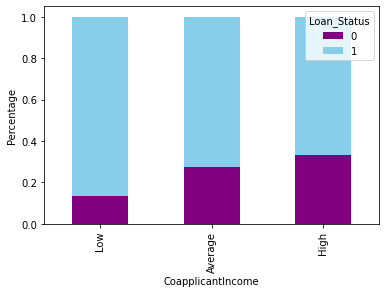

In [46]:
# Visualize the coapplicant income bins by loan status
Coapplicant_Income_bin=pd.crosstab(clean_loan['Coapplicant_Income_bin'],clean_loan['Loan_Status'])
Coapplicant_Income_bin.div(Coapplicant_Income_bin.sum(1).astype(float), axis=0).plot(kind="bar", stacked=True, color = ['purple', 'skyblue'])
plt.xlabel('CoapplicantIncome')
P= plt.ylabel('Percentage')

* It shows that if co-applicants income is less the chances of loan approval are high. But this does not look right. The possible reason behind this may be that most of the applicants don’t have any co-applicant so the co-applicant income for such applicants is 0 and hence the loan approval is not dependent on it. So we can make a new variable in which we will combine the applicant’s and co applicants’ income to visualize the combined effect of income on loan approval.


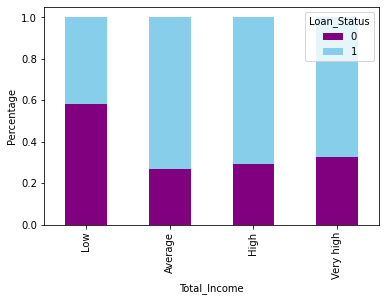

In [47]:
# Bin total income into 4 bins
clean_loan['Total_Income']=clean_loan['ApplicantIncome']+clean_loan['CoapplicantIncome']

bins=[0,2500,4000,6000,81000]
group=['Low','Average','High', 'Very high'] 
clean_loan['Total_Income_bin']=pd.cut(clean_loan['Total_Income'],bins,labels=group)

Total_Income_bin=pd.crosstab(clean_loan['Total_Income_bin'],clean_loan['Loan_Status']) 
Total_Income_bin.div(Total_Income_bin.sum(1).astype(float), axis=0).plot(kind="bar", stacked=True, color = ['purple', 'skyblue']) 
plt.xlabel('Total_Income') 
P = plt.ylabel('Percentage')


In [48]:
# Bin the LoanAmount variable into 3 bins
bins=[0,100,200,700]
group=['Low','Average','High']
clean_loan['LoanAmount_bin']=pd.cut(clean_loan['LoanAmount'],bins,labels=group)

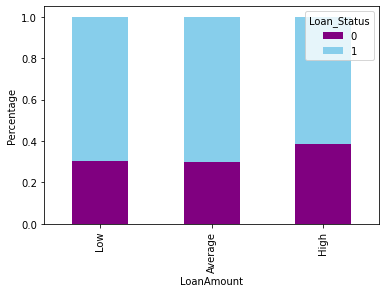

In [49]:
# Visualize the loan amount bins by loan status
LoanAmount_bin=pd.crosstab(clean_loan['LoanAmount_bin'],clean_loan['Loan_Status']) 
LoanAmount_bin.div(LoanAmount_bin.sum(1).astype(float), axis=0).plot(kind="bar", stacked=True, color = ['purple', 'skyblue'])
plt.xlabel('LoanAmount') 
P = plt.ylabel('Percentage')


* It can be seen that the proportion of approved loans is higher for Low and Average Loan Amounts as compared to that of High Loan Amounts which supports our hypothesis which considered that the chances of loan approval will be high when the loan amount is less.

##### Random Forest Classifier

In [ ]:
model_a = RandomForestClassifier()
model_a.fit(x_train, y_train)
pred = model_a.predict(x_test)
forest = accuracy_score(y_test, pred)


##### KNeighborsClassifier

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
model = KNeighborsClassifier()
model.fit(x_train, y_train)
pred = model.predict(x_test)
k = accuracy_score(y_test, pred)


##### Naive Bayes classifier(MultinomialNB)

In [52]:
from sklearn.naive_bayes import MultinomialNB
model = MultinomialNB()
model.fit(x_train, y_train)
pred = model.predict(x_test)
MB= accuracy_score(y_test, pred)

##### Naive Bayes classifier(GaussianNB)

In [53]:
from sklearn.naive_bayes import GaussianNB
model = GaussianNB()
model.fit(x_train, y_train)
pred = model.predict(x_test)
GB=accuracy_score(y_test, pred)

##### Logistic Regression 

In [ ]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression()
model.fit(x_train, y_train)
pred = model.predict(x_test)
LR=accuracy_score(y_test, pred)

##### Decision Tree Classifier

In [ ]:
from sklearn.tree import DecisionTreeClassifier
model = DecisionTreeClassifier()
model.fit(x_train, y_train)
pred = model.predict(x_test)
DTC=  accuracy_score(y_test, pred)

In [56]:
# Comparing the accuracy of the models
print("Random Forest Classifier: ", forest)
print("K Neighbors Classifier: ", k)
print("Multinomial Naive Bayes: ", MB)
print("Gaussian Naive Bayes: ", GB)
print("Logistic Regression: ", LR)
print("Decision Tree Classifier: ", DTC)


Random Forest Classifier:  0.7235772357723578
K Neighbors Classifier:  0.6097560975609756
Multinomial Naive Bayes:  0.5365853658536586
Gaussian Naive Bayes:  0.7804878048780488
Logistic Regression:  0.7967479674796748
Decision Tree Classifier:  0.6991869918699187


* From the above accuracy of the models, we can conclude that Logistic regression will be the best model to use for the predication application.

##### **Logistic Regression Using Stratified k-folds Cross-validation**

To check how robust our model is to unseen data, we can use Validation. It is a technique that involves reserving a particular sample of a dataset on which you do not train the model. Later, you test your model on this sample before finalizing it. Some of the common methods for validation are listed below:

* The validation set approach
* k-fold cross-validation
* Leave one out cross-validation (LOOCV)
* Stratified k-fold cross-validation

In [57]:
# Import StratifiedKFold from sklearn
from sklearn.model_selection import StratifiedKFold

In [67]:
i=1
kf = StratifiedKFold(n_splits=5,random_state=1,shuffle=True) 
for train_index,test_index in kf.split(x_train,y_train):
     print('n{} of kfold {}'.format(i,kf.n_splits))
     xtr,xvl = x_train.iloc[train_index],x_train.iloc[test_index]
     ytr,yvl = y_train.iloc[train_index],y_train.iloc[test_index]
     model = LogisticRegression(random_state=1)
     model.fit(xtr, ytr)
     pred_test = model.predict(xvl)
     score = accuracy_score(yvl,pred_test)
     print('accuracy_score',score)
     i+=1


pred_test = model.predict(x_test)
pred=model.predict_proba(xvl)[:,1]

n1 of kfold 5
accuracy_score 0.7777777777777778
n2 of kfold 5
accuracy_score 0.7755102040816326
n3 of kfold 5
accuracy_score 0.8163265306122449
n4 of kfold 5
accuracy_score 0.8469387755102041
n5 of kfold 5
accuracy_score 0.8367346938775511


c:\Users\vasan\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:670: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  test_folds = np.zeros(n_samples, dtype=np.int)
c:\Users\vasan\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:442: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review

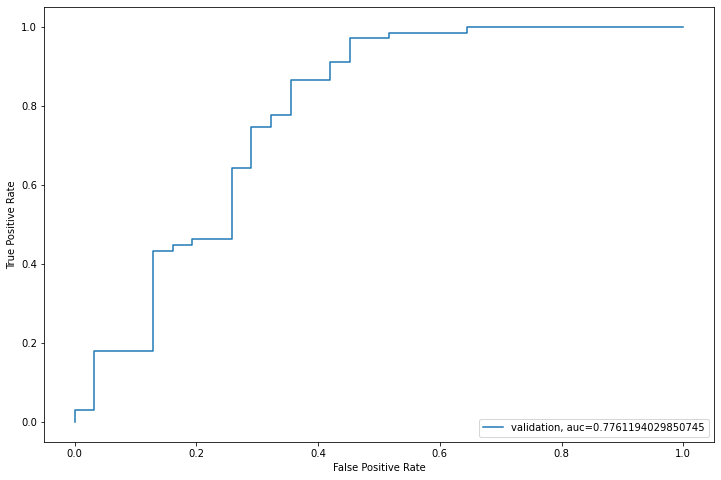

In [59]:
from sklearn import metrics
fpr, tpr, _ = metrics.roc_curve(yvl,  pred)
auc = metrics.roc_auc_score(yvl, pred) 
plt.figure(figsize=(12,8)) 
plt.plot(fpr,tpr,label="validation, auc="+str(auc))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc=4)
plt.show()


#### **Prediction Application using Pickle**

In [60]:
# import joblib to save the model
import joblib

In [61]:
# Saving the model
joblib.dump(model_a, "Loan_status.pkl")

['Loan_status.pkl']

In [62]:
# Get all values from the data
n= data.iloc[:,:].values

In [63]:
# Predicting the values
m = n[0]
m = np.array([m])

In [ ]:
# Building the model to predict the values
model.predict(m)

<AxesSubplot:>

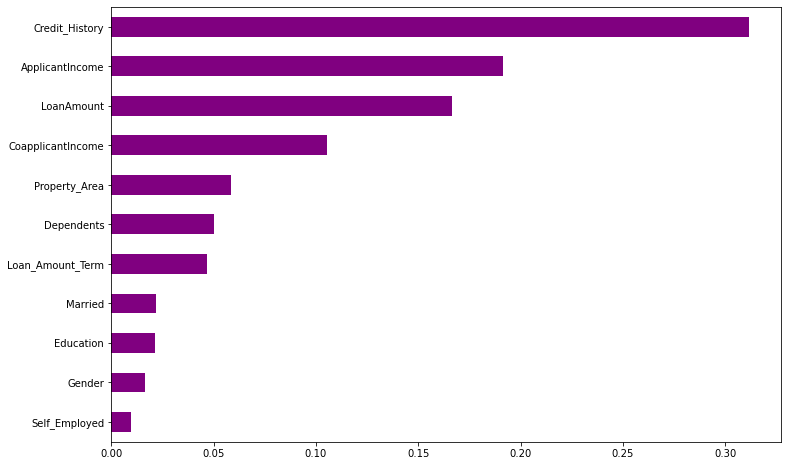

In [65]:
# Graphical representation of the feature importance in the model
importances=pd.Series(model_a.feature_importances_, index=data.columns) 
# sort feature importances from high to low
importances.sort_values(inplace=True)
importances.plot(kind='barh', figsize=(12,8), color='purple')